In [1]:
from online_batches import online_batches
from ml_models import ml_model
from matplotlib import pyplot as plt

In [2]:
ob = online_batches()
ml = ml_model(ob)

2/2 [==============================] - 0s 7ms/step


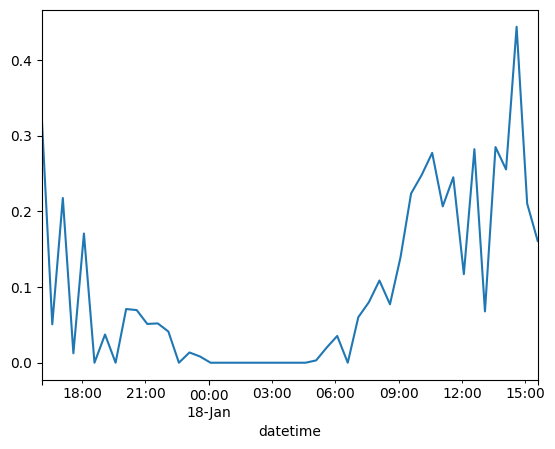

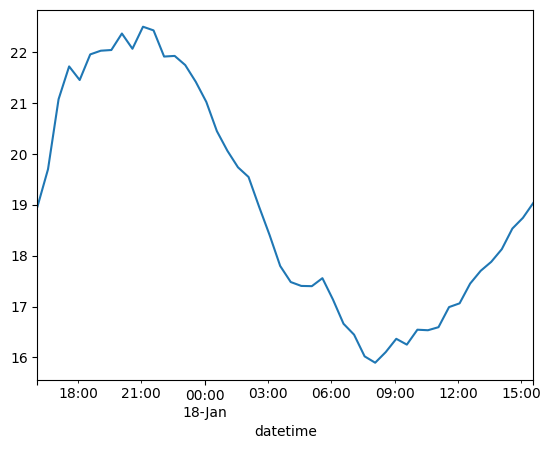

2/2 [==============================] - 0s 8ms/step


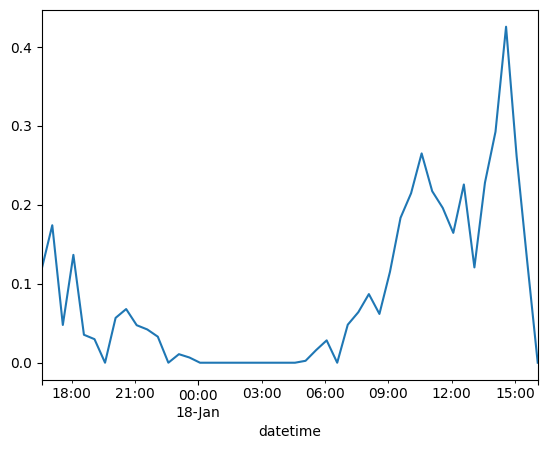

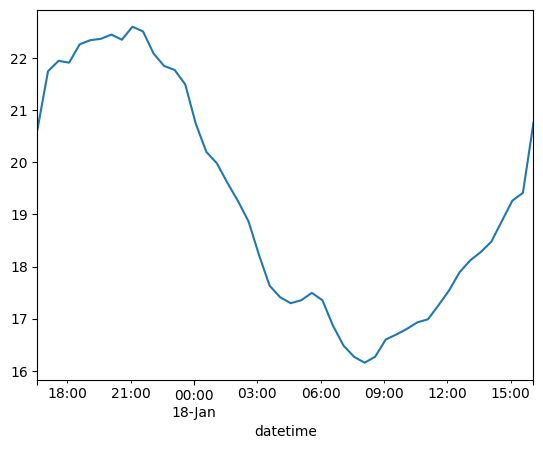

2/2 [==============================] - 0s 7ms/step


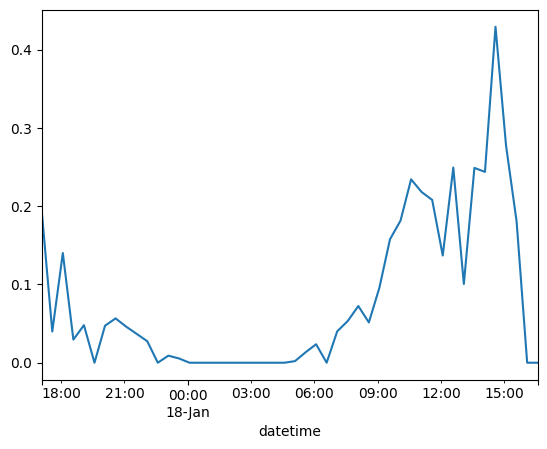

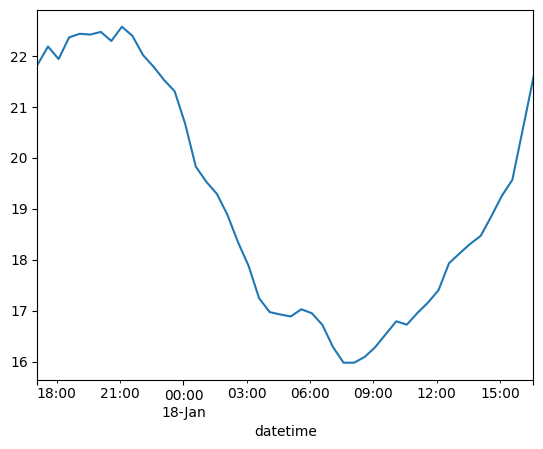

In [4]:
for i in range(3):
    T_out, Ins_PV, Load = ml.predict(i,ob)
    Ins_PV.plot()
    plt.show()
    T_out.plot()
    plt.show()

In [ ]:
print(ob.data["solar"]["Y_test_batches"][:48])

In [ ]:
ob.get_timestamps()[:48]

In [ ]:
plt.plot(ob.get_timestamps()[:48], ob.data["solar"]["Y_test_batches"][:48][0])
plt.xticks(rotation=90, ha="right")